In [141]:
# Imports, as always...
from pathlib import Path

import numpy as np
import pandas as pd

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
# Raw data.
raw_data = pd.concat([
    pd.read_csv(data_csv) 
    for data_csv in Path('./data/depth-varied').glob('*.csv')
], ignore_index=True)

In [4]:
# Computing features from the raw data.
def get_features(df : pd.DataFrame, feature_type : str) -> torch.Tensor:
    # Small value for div-by-zero handling.
    eps = 1e-6
    
    # Fixed n.
    n = df['n'].iloc[0]
    
    # Relevant columns.
    x_cols = [col for col in df.columns if col.startswith('x')]
    y_cols = [col for col in df.columns if col.startswith('y')]
    
    # Relevant values.
    x_probs = torch.tensor(df[x_cols].values, dtype=torch.float64)
    y_probs = torch.tensor(df[y_cols].values, dtype=torch.float64)
    
    # Per-outcome feature types...
    
    if feature_type == 'raw':
        return x_probs
    
    if feature_type == 'res':
        return x_probs - y_probs
    
    if feature_type == 'abs_res':
        return (x_probs - y_probs).abs()
    
    if feature_type == 'rel_res':
        return (x_probs - y_probs) / (y_probs + eps)
    
    if feature_type == 'abs_rel_res':
        return (x_probs - y_probs).abs() / (y_probs + eps)
    
    if feature_type == 'log_ratio':
        return ((x_probs + eps) / (y_probs + eps)).log()
    
    # Per-qubit feature types...
    
    if feature_type == 'qubit_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        qubit_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            qubit_mask = torch.tensor([(j >> i) & 1 == 0 for j in range(2 ** n)], dtype=torch.bool)
            qubit_residuals[:, i] = residuals[:, qubit_mask].sum(dim=1)
            
        return qubit_residuals
    
    if feature_type == 'abs_qubit_res':
        n_samples = x_probs.shape[0]
        residuals = (x_probs - y_probs).abs()
        qubit_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            qubit_mask = torch.tensor([(j >> i) & 1 == 0 for j in range(2 ** n)], dtype=torch.bool)
            qubit_residuals[:, i] = residuals[:, qubit_mask].sum(dim=1)
            
        return qubit_residuals
    
    if feature_type == 'pauli_z_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        pauli_z_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            sign_vector = torch.tensor([1 - 2 * ((j >> i) & 1) for j in range(2 ** n)], dtype=x_probs.dtype)
            weighted_residual = residuals * sign_vector
            pauli_z_residuals[:, i] = weighted_residual.sum(dim=1)
            
        return pauli_z_residuals
    
    if feature_type == 'pauli_zz_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        
        n_pairs = n * (n - 1) // 2
        pauli_zz_residuals = torch.zeros(n_samples, n_pairs, dtype=x_probs.dtype)
        
        pair_idx = 0
        
        for i in range(n):
            for j in range(i + 1, n):
                sign_vector = torch.zeros(32, dtype=x_probs.dtype)
                for b in range(2 ** n):
                    b_i = (b >> i) & 1
                    b_j = (b >> j) & 1

                    if b_i == b_j: sign_vector[b] = 1.0
                    else: sign_vector[b] = -1.0
                    
                weighted_residual = residuals * sign_vector
                pauli_zz_residuals[:, pair_idx] = weighted_residual.sum(dim=1)
                pair_idx += 1
                
        return pauli_zz_residuals

In [195]:
# Generating a palette around a given central colour (ChatGPT generated).
def palette_around_color(center_color, n=32):
    center = np.array(center_color, dtype=float)

    # Lightest: blend center with white
    lightest = center + (1 - center) * 0.4   # adjust 0.8 for more/less lightening
    
    # Darkest: blend center with black
    darkest = center * 0.6                   # adjust 0.2 for more/less darkening

    # First half = lighter → center
    half = n // 2
    lighter_half = [
        tuple(lightest * (1 - t) + center * t)
        for t in np.linspace(0, 1, half, endpoint=False)
    ]

    # Second half = center → darker
    darker_half = [
        tuple(center * (1 - t) + darkest * t)
        for t in np.linspace(0, 1, n - half)
    ]

    return sns.color_palette(lighter_half + darker_half)

In [17]:
# Proper feature names (for plotting).
feature_names = {
    'raw' : 'Raw',
    'res' : 'Residual',
    'abs_res' : 'Residual (Absolute)',
    'rel_res' : 'Residual (Relative)',
    'abs_rel_res' : 'Residual (Absolute, Relative)',
    'log_ratio' : 'Log Ratio',
    'qubit_res' : 'Residual (per Qubit)',
    'abs_qubit_res' : 'Residual (Absolute, per Qubit)',
    'pauli_z_res' : 'Pauli-Z Expectation',
    'pauli_zz_res' : 'Two-Qubit Correlator'
}

## Dimensionality Reduction

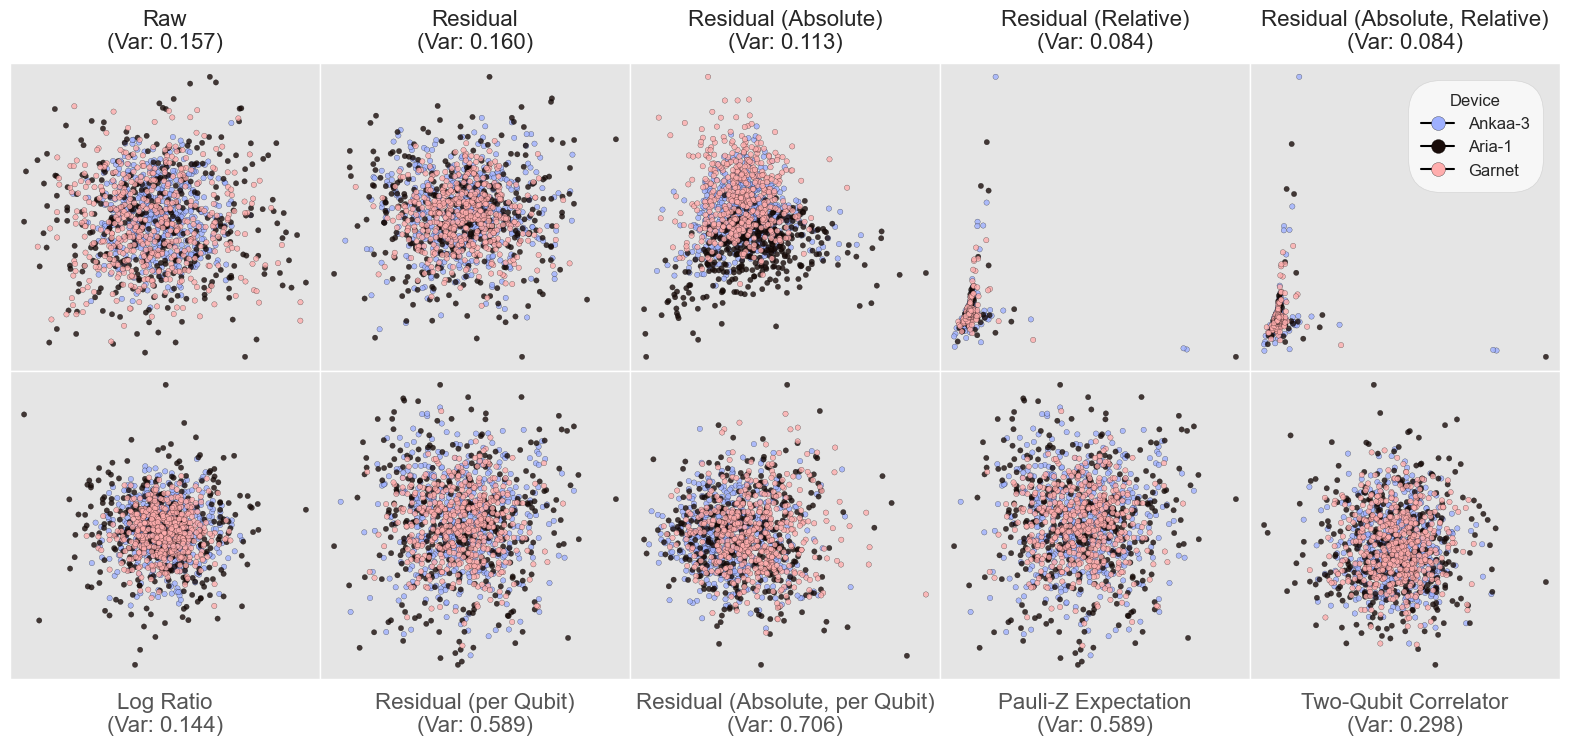

In [81]:
def plot_pca_features(df : pd.DataFrame, file_name : str, cmap):
    # Devices.
    unique_devices = sorted(df['device'].unique())
    n_devices = len(unique_devices)
    device_map = {d: i for i, d in enumerate(unique_devices)}
    device_labels = df['device'].map(device_map).values
    
    # Axes.
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    # Handles.
    legend_handles = [plt.Line2D([0], [0], marker='o', color='k', markerfacecolor=cmap(i/(n_devices-1) if n_devices > 1 else 0), markersize=10, markeredgecolor='k', markeredgewidth=.2, label=d) for i, d in enumerate(unique_devices)]
    
    # Compute features.
    all_features = {feature: get_features(df, feature) for feature in ['raw', 'res', 'abs_res', 'rel_res', 'abs_rel_res', 'log_ratio', 'qubit_res', 'abs_qubit_res', 'pauli_z_res', 'pauli_zz_res']}
    
    for i, (feature, tensor_data) in enumerate(all_features.items()):
        ax = axes[i]
        
        # Standardisation.
        scalar = StandardScaler()
        scaled_data = scalar.fit_transform(tensor_data.numpy())
        
        # PCA.
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(scaled_data)
        total_var = pca.explained_variance_ratio_.sum()
        
        # Plot.
        ax.scatter(
            pca_data[:, 0], 
            pca_data[:, 1], 
            c=device_labels,
            cmap=cmap, 
            vmin=0,
            vmax=n_devices-1,
            s=15, 
            alpha=.8,
            marker='o',
            edgecolor='k',
            linewidth=.2 
        )
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i < 5:
            ax.set_title(f'{feature_names[feature]}\n(Var: {total_var:.3f})', pad=10, fontsize=16)
        else:
            ax.set_xlabel(f'{feature_names[feature]}\n(Var: {total_var:.3f})', labelpad=10, fontsize=16)
        
    leg = plt.legend(
        handles=legend_handles,
        title='Device',
        loc='upper right', 
        bbox_to_anchor=(.95, 1.95),
        fontsize=12,
        title_fontsize=12,
        frameon=True, 
        fancybox=True,    
        framealpha=0.7,       
        facecolor='white', 
    )
    frame = leg.get_frame()
    frame.set_boxstyle('round', pad=0.4, rounding_size=2)  
        
    # Remove all spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if file_name: plt.savefig(file_name, bbox_inches='tight')
    plt.show()
    
cmap = cmc.berlin
plot_pca_features(raw_data[raw_data['d'] == 5], './figures/dim_reduction/pca.pdf', cmap)

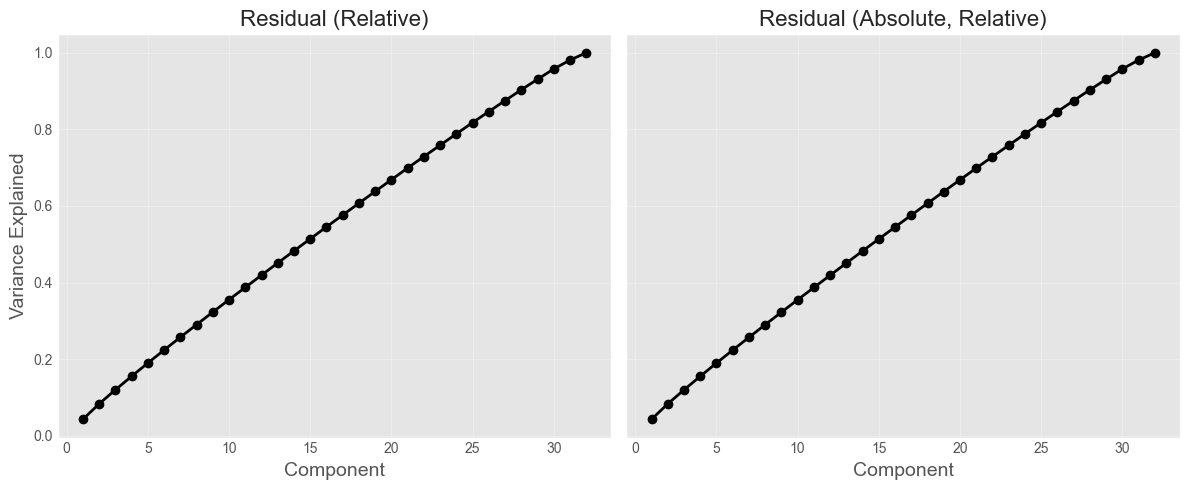

In [84]:
# Scree plot on those relative residuals to see what's going on there.
def plot_scree_multiple(df: pd.DataFrame, features: list, file_name: str = None):
    """
    Create side-by-side scree plots for a list of features.
    """
    n = len(features)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

    # If only one feature → axes is not a list
    if n == 1:
        axes = [axes]

    for ax, feature in zip(axes, features):
        # Extract feature matrix (32-dim for your case)
        X = get_features(df, feature).numpy()

        # Standardise
        scalar = StandardScaler()
        Xs = scalar.fit_transform(X)

        # Full PCA
        pca = PCA()
        pca.fit(Xs)

        var = pca.explained_variance_ratio_
        cumvar = np.cumsum(var)
        comps = np.arange(1, len(var) + 1)

        # Cumulative line
        ax.plot(comps, cumvar, color='black', marker='o', linewidth=2)

        # Cosmetics
        ax.set_title(f"{feature_names[feature]}", fontsize=16)
        ax.set_xlabel("Component", fontsize=14)
        ax.grid(alpha=0.3)

    # Shared y-label
    axes[0].set_ylabel("Variance Explained", fontsize=14)

    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, bbox_inches="tight")

    plt.show()
    
plot_scree_multiple(raw_data[raw_data['d'] == 5], ["rel_res", "abs_rel_res"])

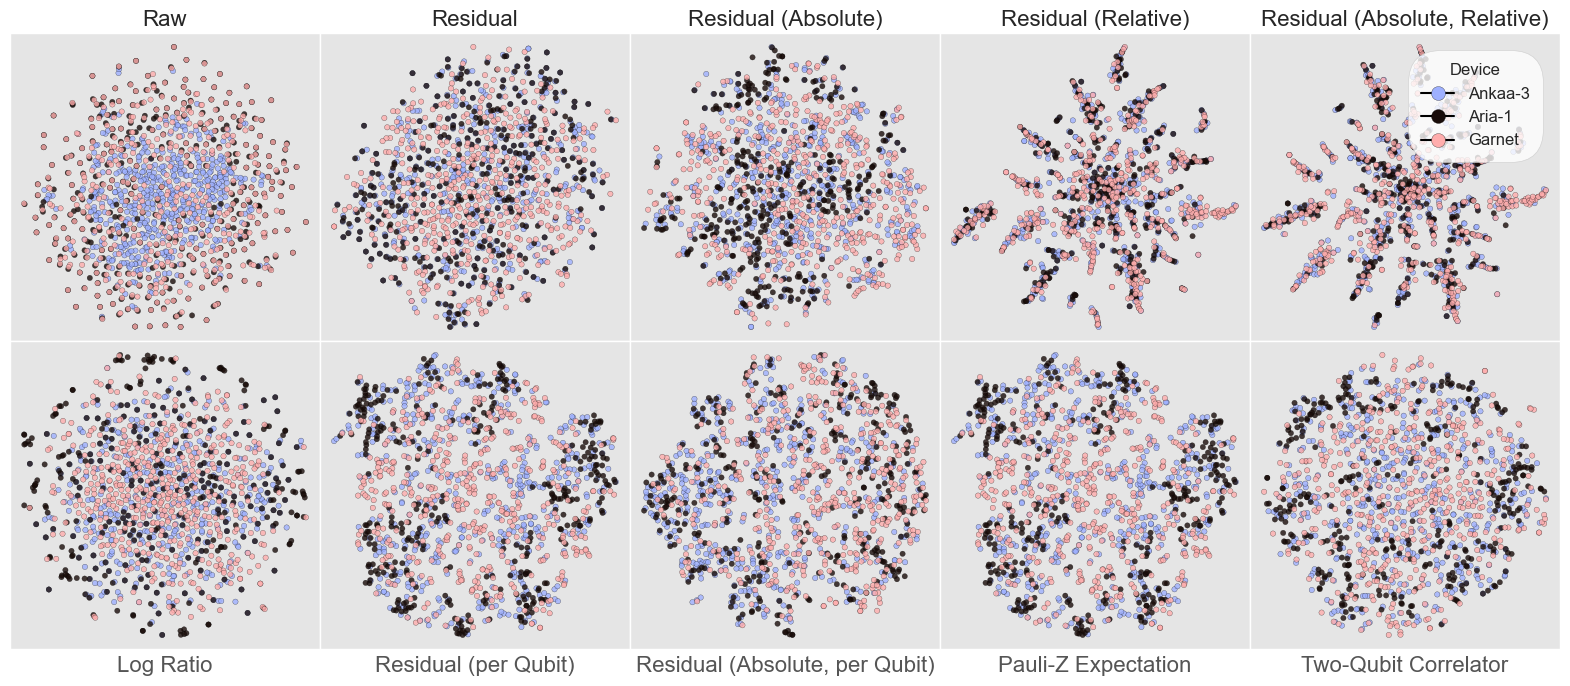

In [82]:
def plot_tsne_features(df : pd.DataFrame, file_name : str, cmap):
    # Devices.
    unique_devices = sorted(df['device'].unique())
    n_devices = len(unique_devices)
    device_map = {d: i for i, d in enumerate(unique_devices)}
    device_labels = df['device'].map(device_map).values
    
    # Axes.
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    # Handles.
    legend_handles = [plt.Line2D([0], [0], marker='o', color='k', markerfacecolor=cmap(i/(n_devices-1) if n_devices > 1 else 0), markersize=10, markeredgecolor='k', markeredgewidth=.2, label=d) for i, d in enumerate(unique_devices)]
    
    # Compute features.
    all_features = {feature: get_features(df, feature) for feature in ['raw', 'res', 'abs_res', 'rel_res', 'abs_rel_res', 'log_ratio', 'qubit_res', 'abs_qubit_res', 'pauli_z_res', 'pauli_zz_res']}
    
    for i, (feature, tensor_data) in enumerate(all_features.items()):
        ax = axes[i]
        
        # Standardisation.
        scalar = StandardScaler()
        scaled_data = scalar.fit_transform(tensor_data.numpy())
        
        # TSNE.
        tsne = TSNE(n_components=2, random_state=42)
        tsne_data = tsne.fit_transform(scaled_data)
        
        # Plot.
        ax.scatter(
            tsne_data[:, 0], 
            tsne_data[:, 1], 
            c=device_labels,
            cmap=cmap, 
            vmin=0,
            vmax=n_devices-1,
            s=15, 
            alpha=.8,
            marker='o',
            edgecolor='k',
            linewidth=.2 
        )
        
        ax.set_xticks([])
        ax.set_yticks([])

        if i < 5:
            ax.set_title(f'{feature_names[feature]}', pad=5, fontsize=16)
        else:
            ax.set_xlabel(f'{feature_names[feature]}', labelpad=5, fontsize=16)
        
    leg = plt.legend(
        handles=legend_handles,
        title='Device',
        loc='upper right', 
        bbox_to_anchor=(.95, 1.95),
        fontsize=12,
        title_fontsize=12,
        frameon=True, 
        fancybox=True,    
        framealpha=.8,       
        facecolor='white', 
    )
    frame = leg.get_frame()
    frame.set_boxstyle('round', pad=0.4, rounding_size=2)  
        
    # Remove all spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if file_name: plt.savefig(file_name, bbox_inches='tight')
    plt.show()
    
cmap = cmc.berlin
plot_tsne_features(raw_data[raw_data['d'] == 5], './figures/dim_reduction/tsne.pdf', cmap)

## Distributions

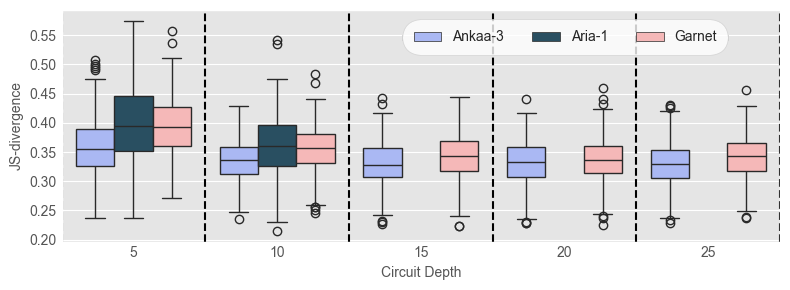

In [206]:
# JS-divergence by depth, hue on device.
fig, ax = plt.subplots(1, 1, figsize=(8, 3), layout='tight')

colours = cmc.berlin([0, .3, 1])
palette = dict(zip(raw_data['device'].unique(), colours))
sns.boxplot(data=raw_data, x='d', y='js_div_exp_vs_true', hue='device', ax=ax, palette=palette)

# Beautification.
ax.set_xlabel('Circuit Depth', fontsize=10)
ax.set_ylabel('JS-divergence', fontsize=10)
#ax.set_ylim(.15, .75)

leg = plt.legend(
    #handles=legend_handles,
    #title='Device',
    loc='upper right', 
    bbox_to_anchor=(.93, .966),
    fontsize=10,
    title_fontsize=10,
    frameon=True, 
    fancybox=True,    
    framealpha=.8,       
    facecolor='white', 
    ncol=3,
)
frame = leg.get_frame()
frame.set_boxstyle('round', pad=0.4, rounding_size=1.5)  

# Dividing lines for clarity.
for i in range(raw_data['d'].nunique() + 1):
    ax.axvline(i - .5, color='k', linestyle='--')
    
plt.savefig('./figures/distribution/box_plot_by_depth.pdf', bbox_inches='tight')

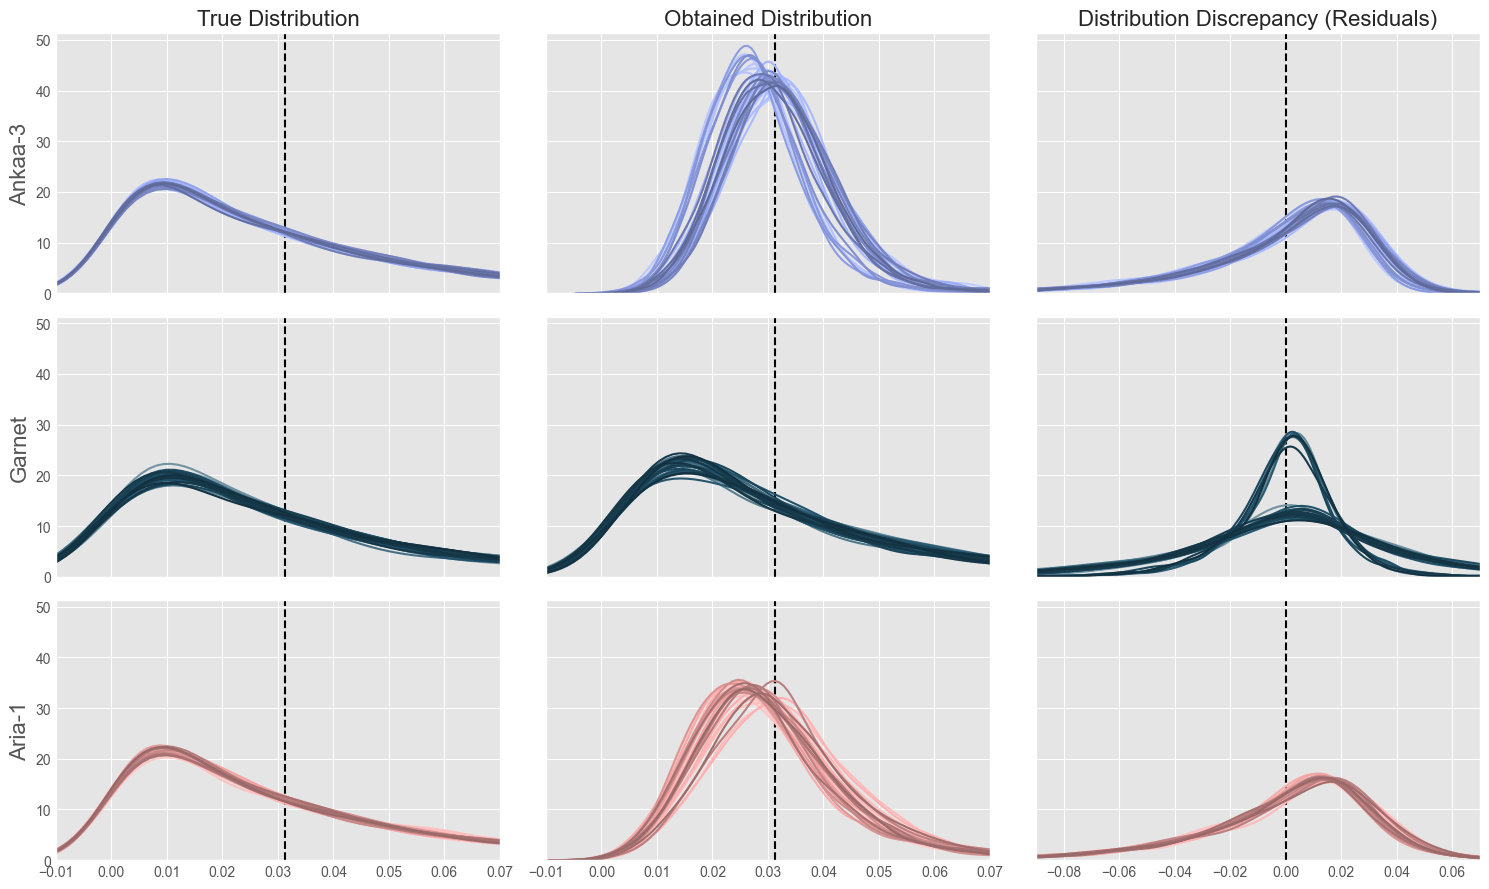

In [203]:
# Distribution of distributions.
fig, axes = plt.subplots(3, 3, figsize=(15, 9), sharex='col', sharey='all', layout='tight')

# Setup.
colours = cmc.berlin([0, .3, 1])
palette = [palette_around_color(colours[i], 32) for i in range(3)]

# State distributions.
for i, state in enumerate([format(i, f'0{5}b') for i in range(2 ** 5)]):
    for j, device in enumerate(raw_data['device'].unique()):
        sns.distplot(raw_data[raw_data['device'] == device]['y' + state], hist=False, color=palette[j][i], ax=axes[j][0])
        sns.distplot(raw_data[raw_data['device'] == device]['x' + state], hist=False, color=palette[j][i], ax=axes[j][1])
        sns.distplot(raw_data[raw_data['device'] == device][state], hist=False, color=palette[j][i], ax=axes[j][2])

# Beautification.
[ax.set_xlabel('') for ax in axes.flatten()]

axes[0][0].set_ylabel('Ankaa-3', fontsize=16)
axes[1][0].set_ylabel('Garnet', fontsize=16)
axes[2][0].set_ylabel('Aria-1', fontsize=16)
axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
axes[0][2].set_ylabel('')
axes[1][2].set_ylabel('')
axes[2][1].set_ylabel('')
axes[2][2].set_ylabel('')
axes[0][2].set_title('Distribution Discrepancy (Residuals)', fontsize=16)
axes[0][1].set_title('Obtained Distribution', fontsize=16)
axes[0][0].set_title('True Distribution', fontsize=16)

axes[0][2].set_xlim(-.09, .07)
axes[0][1].set_xlim(-.01, .07)
axes[0][0].set_xlim(-.01, .07)

axes[0][0].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[1][0].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[0][1].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[1][1].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[2][0].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[2][1].axvline(1/32, color='k', linestyle='--', zorder=1)
axes[0][2].axvline(0, color='k', linestyle='--', zorder=1)
axes[1][2].axvline(0, color='k', linestyle='--', zorder=1)
axes[2][2].axvline(0, color='k', linestyle='--', zorder=1)

plt.savefig('./figures/distribution/distributions_grid_plot.pdf', bbox_inches='tight')